<a href="https://colab.research.google.com/github/worklifesg/Natural-Language-Processing/blob/main/Projects/4.%20Twitter%20Combat%20Hate%20Speech%20Project/Help_Twitter_Combat_Hate_Speech_NLP_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 align='center'> Help Twitter Combat Hate Speech Using NLP and Machine Learning 

By: Shraman Gupta </h3>

<b> Problem Statement: </b>  

Twitter is the biggest platform where anybody and everybody can have their views heard. Some of these voices spread hate and negativity. Twitter is wary of its platform being used as a medium  to spread hate. 

You are a data scientist at Twitter, and you will help Twitter in identifying the tweets with hate speech and removing them from the platform. You will use NLP techniques, perform specific cleanup for tweets data, and make a robust model.

<b> Analysis to be done: </b>

- Clean up tweets and build a classification model by using NLP techniques, cleanup specific for tweets data, regularization and hyperparameter tuning using stratified k-fold and cross validation to get the best model.

  - Content: 
  - id: identifier number of the tweet
  - Label: 0 (non-hate) /1 (hate)
  - Tweet: the text in the tweet

##### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
from nltk.tokenize import TweetTokenizer

from nltk.corpus import stopwords
from string import punctuation

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold

##### 2. Load the tweets file using read_csv function from Pandas package. 

In [2]:
#Reading the dataset
df_tweets = pd.read_csv('TwitterHate.csv')
df_tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


<b> <i> <u> Comment: </u> </i> </b>  So we have id for each tweet with label as 0/1 for non-hate or hate tweet

Before jumping to the text-preprocessing in the pipeline, let us check the data visualization

In [3]:
#Checking dataset information to verify if there is any null text

df_tweets.info() #So no null values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


Total number of tweets: 31962
Number of Non Hate Tweets: 29720
Nubmer of Hate Tweets: 2242


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


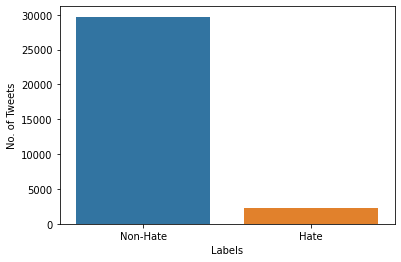

In [4]:
import seaborn as sns;

#Checking number of non-hate(0) and hate(1) texts
print('Total number of tweets: {}'.format(df_tweets.shape[0]))
print('Number of Non Hate Tweets: {}'.format(df_tweets[df_tweets.label==0].shape[0]))
print('Nubmer of Hate Tweets: {}'.format(df_tweets[df_tweets.label==1].shape[0])) 

ax = sns.countplot(df_tweets['label'],label="Labels");
plt.ylabel('No. of Tweets');
plt.xlabel('Labels');
plt.xticks((0,1), ('Non-Hate', 'Hate'));

The given dataset is imbalanced therefore the predicted model can be baised in certain cases

Before jumping to text pre-processing let us explore the data thorugh data visualization (histograms, wordcloud)


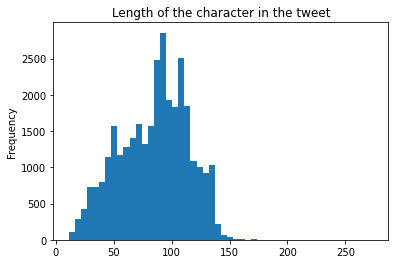

In [5]:
#Checking the frequency of length of the character in the tweet

plt.figure(figsize=(6,4))
plt.hist(x=df_tweets['tweet'].map(lambda x:len(x)), bins=50);
plt.ylabel('Frequency')
plt.title('Length of the character in the tweet');

In [6]:
#let us check a text of length

df_tweets['Length'] = df_tweets['tweet'].apply(len) #adding Length column in dataframe
print('Max Length: ',df_tweets['Length'].max())
df_tweets.head()

Max Length:  274


,id,label,tweet,Length
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39


<b> <i> <u> Comment: </u> </i> </b>  

- Mostly the length of tweets are between 80-120 characters.
- The max length of the tweet in the given dataset is 274


In [7]:
#checking just few text in the tweet

#first tweet
df_tweets[df_tweets['Length']== 102]['tweet'].iloc[0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [8]:
#Create a word cloud for hate and non-hate words in a tweet message
import nltk
nltk.download('punkt')
#empty list of ham and spam
words_nonhate = ''
words_hate = ''

#using for loop to check label with spam and ham and use tokenize to convert sentence to words

for i in df_tweets[df_tweets['label']==1].tweet:
  text = i.lower()
  tokens = nltk.word_tokenize(text)
  for words in tokens:
    words_hate = words_hate + words + ' '

for i in df_tweets[df_tweets['label']==0].tweet:
  text = i.lower()
  tokens = nltk.word_tokenize(text)
  for words in tokens:
    words_nonhate = words_nonhate + words + ' '

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


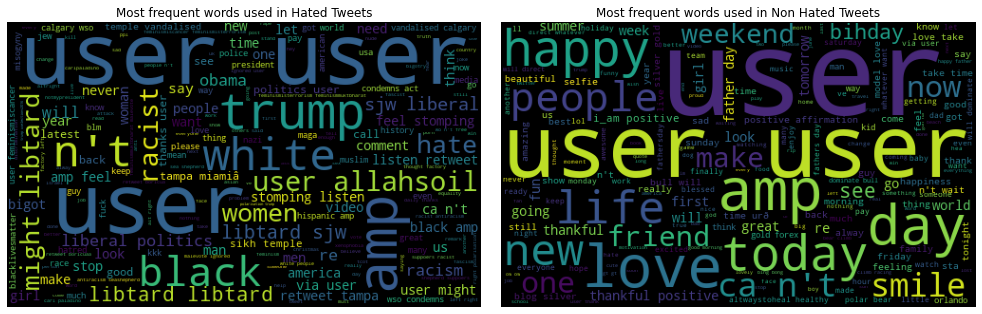

In [9]:
from wordcloud import WordCloud
wcloud_hate = WordCloud(width=500,height=300).generate(words_hate)
wcloud_nonhate = WordCloud(width=500,height=300).generate(words_nonhate)

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(wcloud_hate)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Most frequent words used in Hated Tweets');
plt.subplot(122)
plt.imshow(wcloud_nonhate)
plt.axis('off')
plt.tight_layout(pad=2)
plt.title('Most frequent words used in Non Hated Tweets');

##### 3. Get the tweets into a list for easy text cleanup and manipulation.

In [10]:
df_list = df_tweets.tweet.values
df_list[:3] #checking first 3 tweets

array([' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
       "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
       '  bihday your majesty'], dtype=object)

##### 4. To cleanup: 

- Normalize the casing.
- Using regular expressions, remove user handles. These begin with '@’.
- Using regular expressions, remove URLs.
- Using TweetTokenizer from NLTK, tokenize the tweets into individual terms.
- Remove stop words.
- Remove redundant terms like ‘amp’, ‘rt’, etc.
- Remove ‘#’ symbols from the tweet while retaining the term.

##### 5. Extra cleanup by removing terms with a length of 1.


In [11]:
#defining the function to have text pre-processing

handle = '@\w+' # Replace email addresses with ''
url =  '\w+://\S+' #Replace URLs with ''
hashtag = '#' #hashtag


# Access stop words, punctuations, reduntant terms
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_punct = list(punctuation)
stop_punct.extend(['...','``',"''",".."])
stop_context = ['rt', 'amp']
stop_final = stop_words + stop_punct + stop_context


def text_processing(tweet):
  assert(type(tweet)==str)

  text_clean = tweet.lower() #Normalize the casing.

  text_clean = re.sub(handle,'',text_clean) #Using regular expressions, remove user handles. These begin with '@’.
  text_clean = re.sub(url,'',text_clean) #Using regular expressions, remove URLs.

  token=TweetTokenizer() #Using TweetTokenizer from NLTK, tokenize the tweets into individual terms.
  text_clean = token.tokenize(text_clean)

  return text_clean

def clean_up(sent):
  return [re.sub(hashtag,'',term)for term in sent if ((term not in stop_final) & (len(term)>1))] #Remove ‘#’ symbols from the tweet while retaining the term.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#Checking the tweet clean up process after text processing
text = text_processing(df_list[0])
final_text = clean_up(text)
print(text)
print(final_text)

['when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction', '.', '#run']
['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run']


In [13]:
#Applying text processing and clean up to all tweets
processed_text = df_tweets['tweet'].apply(text_processing)
final_clean_tweets = [clean_up(tweet) for tweet in processed_text]
final_clean_tweets[:3]

[['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run'],
 ['thanks',
  'lyft',
  'credit',
  "can't",
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdx',
  'disapointed',
  'getthanked'],
 ['bihday', 'majesty']]

##### 6. Check out the top terms in the tweets:

 - First, get all the tokenized terms into one large list.
 - Use the counter and find the 10 most common terms.



In [14]:
#Creating an empty list to store all top listed terms
top_terms = []
for tweet in final_clean_tweets:top_terms.extend(tweet)

toppr = Counter(top_terms)
toppr.most_common(10)

[('love', 2748),
 ('day', 2276),
 ('happy', 1684),
 ('time', 1131),
 ('life', 1118),
 ('like', 1047),
 ("i'm", 1018),
 ('today', 1013),
 ('new', 994),
 ('thankful', 946)]

In [15]:
#Having top terms dataframe

df_top_terms = pd.DataFrame.from_dict(toppr, orient='index').reset_index()
df_top_terms = df_top_terms.rename(columns={'index':'Terms', 0:'count'})
df_top_terms.head()

,Terms,count
0,father,202
1,dysfunctional,1
2,selfish,13
3,drags,4
4,kids,204


In [16]:
#Sorting the top terms in descending order
df_top_terms_sort = df_top_terms.sort_values(by=['count'],ascending=False)
df_top_terms_sort.head()

,Terms,count
22,love,2748
152,day,2276
153,happy,1684
24,time,1131
283,life,1118


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


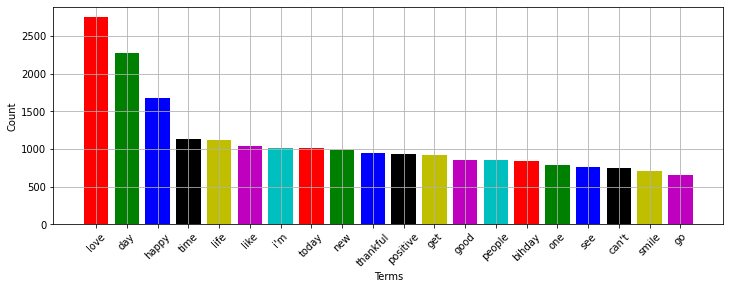

In [17]:
#Data visualization for top terms used in tweets.
plt.figure(figsize=(12,4))
plt.bar(df_top_terms_sort['Terms'][:20],df_top_terms_sort['count'][:20],
        color='rgbkymc')
plt.xticks(rotation=45)
plt.xlabel('Terms')
plt.ylabel('Count')
plt.grid()

<i> It can be seen that the most term is <b> love </b> with 2748 counts </i>

##### 7. Data formatting for predictive modeling:

- Join the tokens back to form strings. This will be required for the vectorizers.
- Assign x and y.
- Perform train_test_split using sklearn.

In [18]:
#joining tokens back to form strings for each tweet
final_tweet_complete = [' '.join(text) for text in final_clean_tweets]
final_tweet_complete[:3]

['father dysfunctional selfish drags kids dysfunction run',
 "thanks lyft credit can't use cause offer wheelchair vans pdx disapointed getthanked",
 'bihday majesty']

In [19]:
#Now assigning x,y for implementing machine learning algorithm

x = final_tweet_complete
y = df_tweets.label.values

#Splitting the data 70/30
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

##### 8. We’ll use TF-IDF values for the terms as a feature to get into a vector space model.

- Import TF-IDF  vectorizer from sklearn.
- Instantiate with a maximum of 5000 terms in your vocabulary.
- Fit and apply on the train set.
- Apply on the test set.

In [20]:
# Import TF-IDF vectorizer from sklearn.
# Instantiate with a maximum of 5000 terms in your vocabulary.

vector = TfidfVectorizer(max_features = 5000)

#Fit and apply on the train set.
X_train = vector.fit_transform(X_train)
#Apply on the test set
X_test = vector.transform(X_test)

print('Training size : ',X_train.shape)
print('Testing size : ', X_test.shape)

Training size :  (22373, 5000)
Testing size :  (9589, 5000)


##### 9. Model building: Ordinary Logistic Regression

- Instantiate Logistic Regression from sklearn with default parameters.
- Fit into  the train data.
- Make predictions for the train and the test set.

In [21]:
#Instantiate Logistic Regression
LR_model = LogisticRegression()

#Fit into the train data.
LR_model.fit(X_train,y_train)

#Predictions for train and test data
y_tr_pred = LR_model.predict(X_train)
y_ts_pred = LR_model.predict(X_test)

##### 10. Model evaluation: Accuracy, recall, and f_1 score.

- Report the accuracy on the train set.
- Report the recall on the train set: decent, high, or low.
- Get the f1 score on the train set.


In [22]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

print('Accuracy score is : ',accuracy_score(y_train,y_tr_pred))
print('Recall is : ',recall_score(y_train,y_tr_pred))
print('F1 score is : ',f1_score(y_train,y_tr_pred))
print('----------------------------------------------------------------')
print(classification_report(y_train,y_tr_pred))

Accuracy score is :  0.9560184150538595
Recall is :  0.38575096277278564
F1 score is :  0.5498627630375114
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     20815
           1       0.96      0.39      0.55      1558

    accuracy                           0.96     22373
   macro avg       0.96      0.69      0.76     22373
weighted avg       0.96      0.96      0.95     22373



<b> The recall score for hate tweets vcategory is pretty low as it is am imbalanced dataset, so overall the model seems to focus more on the 0s (non-hate)</b>

So we need to set the balance in our evaluation


##### 11. Looks like you need to adjust the class imbalance, as the model seems to focus on the 0s.

- Adjust the appropriate class in the LogisticRegression model.



In [23]:
#Creating another Logistic Regression Model with balanced class

LR_model2 = LogisticRegression(class_weight='balanced')

##### 12. Train again with the adjustment and evaluate.

- Train the model on the train set.
- Evaluate the predictions on the train set: accuracy, recall, and f_1 score.



In [24]:
#Train the model on the train set.
LR_model2.fit(X_train,y_train)

#Predictions modified for balanced dataset
y_tr_pred2 = LR_model2.predict(X_train)
y_ts_pred2 = LR_model2.predict(X_test)

print('Modified Accuracy score is : ',accuracy_score(y_train,y_tr_pred2))
print('Modified Recall is : ',recall_score(y_train,y_tr_pred2))
print('Modified F1 score is : ',f1_score(y_train,y_tr_pred2))
print('----------------------------------------------------------------')
print(classification_report(y_train,y_tr_pred2))

Modified Accuracy score is :  0.9535153980244044
Modified Recall is :  0.9749679075738126
Modified F1 score is :  0.744973025993134
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     20815
           1       0.60      0.97      0.74      1558

    accuracy                           0.95     22373
   macro avg       0.80      0.96      0.86     22373
weighted avg       0.97      0.95      0.96     22373



<b> Now recall score and F1 score looks good for both classes</b>

##### 13. Regularization and Hyperparameter tuning:

- Import GridSearch and StratifiedKFold because of class imbalance.
- Provide the parameter grid to choose for ‘C’ and ‘penalty’ parameters.
- Use a balanced class weight while instantiating the logistic regression.



In [25]:
# In this part we will perform Regularization and hyperparameters tunings to get maximum accuracy and best predicition

param_grid = [
    {'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20)}
]

LR_model_reg = LogisticRegression(class_weight='balanced')

##### 14. Find the parameters with the best recall in cross validation.

- Choose ‘recall’ as the metric for scoring.
- Choose stratified 4 fold cross validation scheme.
- Fit into  the train set.

In [26]:
grid = GridSearchCV(estimator=LR_model_reg,
                    param_grid=param_grid,
                    cv=StratifiedKFold(4),
                    n_jobs=-1,
                    verbose=1,
                    scoring='recall')
grid.fit(X_train,y_train)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='d...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
        

##### 15. What are the best parameters?

In [27]:
grid.best_estimator_

LogisticRegression(C=0.23357214690901212, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### 16. Predict and evaluate using the best estimator.

- Use the best estimator from the grid search to make predictions on the test set.
- What is the recall on the test set for the toxic comments?
- What is the f_1 score?

In [28]:
#predictions on test dataset using best parameters extracted from GridSearchCV
y_ts_pred_reg = grid.best_estimator_.predict(X_test)

print('Modified Accuracy score is : ',accuracy_score(y_test,y_ts_pred_reg))
print('Modified Recall is : ',recall_score(y_test,y_ts_pred_reg))
print('Modified F1 score is : ',f1_score(y_test,y_ts_pred_reg))
print('----------------------------------------------------------------')
print(classification_report(y_test,y_ts_pred_reg))

Modified Accuracy score is :  0.9215768067577432
Modified Recall is :  0.7660818713450293
Modified F1 score is :  0.5822222222222222
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      8905
           1       0.47      0.77      0.58       684

    accuracy                           0.92      9589
   macro avg       0.73      0.85      0.77      9589
weighted avg       0.94      0.92      0.93      9589



<b> Solution : </b>

- What is the recall on the test set for the toxic comments?
 - Recall for toxic comments is 0.77
 - Higher recall is better as we have more True Positives, which mean we are able to predict well which one are hate tweets and which one are non-hate tweets. Hate ones still have lower recall than non-hate ones.
- What is the f_1 score?
 - F1: Class '0' - Non-hate --> 0.96
 - F1: Class '1' - Hate --> 0.58
 -  F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall and there is an uneven class distribution (large number of Actual Negatives).
 - Higher F1 is needed as we can detect low false negatives and false positive leading to higher precision

---

<b> Tabulate Prediction Metrics Results: </b>

Case            |Class|Set | Accuracy |Recall | F1 Score
-----------------------|:--------------|:--------------|:--------------:|---------------:|---------------:
Logistic Regression: Unbalanced class weight |'0': Hate| Training | 0.957 | 0.3857 | 0.5498 
Logistic Regression: Unbalanced class weight |'0': Non-Hate| Training | 0.957 | 1 | 0.98 
Logistic Regression: Balanced class weight |'0': Hate| Training | 0.6 | 0.97 | 0.74
Logistic Regression: Balanced class weight |'0': Non-Hate| Training | 1 | 0.95 | 0.97 
Logistic Regression: Balanced (Best params) |'0': Hate| Testing | 0.47 | 0.77| 0.58
Logistic Regression: Balanced (Best params) |'0': Non-Hate| Testing | 0.98 | 0.93 | 0.96  